<a href="https://colab.research.google.com/github/Anjalii-09/Anjalii-09/blob/main/CV_Asmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup for LLM Fine-Tuning

To prepare our environment for fine-tuning a Large Language Model (LLM), we need to install and upgrade several key libraries.

1. **Datasets Library (v2.10.1)**: We install a specific version of the `datasets` library, which provides access to a wide range of datasets and supports efficient data loading, processing, and evaluation.

2. **fsspec**: We upgrade the `fsspec` library, which serves as an interface for file systems, ensuring smooth handling of large datasets and maintaining compatibility with the `datasets` library.

3. **TRL, W&B, and Evaluate**:
   - **TRL (Transformers Reinforcement Learning)**: This library helps in training models with reinforcement learning algorithms.
   - **W&B (Weights & Biases)**: A powerful tool for experiment tracking, enabling us to monitor model training and performance metrics.
   - **Evaluate**: A user-friendly library to compute and analyze evaluation metrics, specifically designed for NLP tasks.

These installations and upgrades are essential to ensure that our environment is fully equipped for the fine-tuning process.




In [ ]:
!pip install datasets==2.10.1
!pip install --upgrade fsspec
!pip install -U datasets
!pip install trl wandb datasets evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
ERROR: Operation cancelled by user
  Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the pa

# Importing Essential Libraries for Fine-Tuning and Evaluation

In this section, we import several key libraries and modules necessary for fine-tuning a Large Language Model (LLM) and evaluating its performance.

- **Datasets and Data Handling:**
  - `load_dataset` from the `datasets` library: Loads and preprocesses datasets for model training and evaluation.
  - `pandas` and `numpy`: Essential libraries for data manipulation, analysis, and numerical operations.

- **Model Training and Evaluation:**
  - `evaluate`: A library used to compute and analyze evaluation metrics, specifically designed for NLP tasks.
  - `pipeline`, `Trainer`, `TrainingArguments`, `AutoModelForSequenceClassification`, and `AutoTokenizer` from `transformers`: Provide tools for defining, training, and evaluating transformer models like DistilBERT.
  - `load_metric`: A function for loading predefined evaluation metrics.
  - `torch`: A deep learning library used for model training and handling tensors.

- **Visualization:**
  - `matplotlib.pyplot`: A plotting library used to visualize model performance before and after fine-tuning.

These imports set up our environment, enabling us to load datasets, fine-tune our model, evaluate its performance, and visualize the results.


In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import evaluate
from transformers import pipeline, Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt
import torch

## Loading the Yelp Review Dataset

We utilize the `datasets` library to load the **Yelp Review Full** dataset, which contains a large corpus of text reviews categorized into different sentiment labels. In this example, we load the dataset and preview a sample from the training set to understand the structure of the data.


In [ ]:
dataset = load_dataset("yelp_review_full")
dataset["train"][100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

## Tokenizing the Dataset

To prepare the data for fine-tuning, we need to tokenize the text using the DistilBERT tokenizer. We perform the following steps:

1. **Load the DistilBERT Tokenizer**: We use the `AutoTokenizer` class from the `transformers` library to load the tokenizer for the DistilBERT model.

2. **Define a Tokenization Function**: This function processes the text by padding it to the maximum length and truncating it if necessary.

3. **Apply Tokenization**: We apply this function to the entire dataset to convert the raw text into a format suitable for model training.


In [ ]:
# Load DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Creating Smaller Subsets of the Dataset

To expedite the training and evaluation processes, we create smaller subsets from the tokenized datasets:

1. **Small Training Dataset**: We randomly select 1,000 samples from the training set. This helps in quicker experimentation and debugging.

2. **Small Evaluation Dataset**: Similarly, we select 1,000 samples from the test set to use for evaluation.

We use a fixed seed for shuffling to ensure reproducibility of the subsets.


In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

## Loading the DistilBERT Model for Sequence Classification

We load the DistilBERT model pre-trained for sequence classification tasks. This model is fine-tuned to predict sentiment labels across five classes. The key steps are:

1. **Load the Model**: Using the `AutoModelForSequenceClassification` class from the `transformers` library, we initialize the model with the pre-trained weights from `distilbert-base-cased`.

2. **Specify Number of Labels**: We configure the model to output predictions for 5 sentiment categories.


In [ ]:
# Load DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=5)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Configuring Training Arguments

We define the training parameters using the `TrainingArguments` class from the `transformers` library. In this step:

 **Initialize Training Arguments**: We specify the output directory where the model checkpoints and logs will be saved. This is essential for managing and reviewing training progress.

   - **`output_dir`**: The directory where the model checkpoints and training logs will be stored.


In [ ]:
training_args = TrainingArguments(output_dir="test_trainer")

**Load Accuracy Metric**: We use the `evaluate` library to load the accuracy metric, which will be used to assess the performance of our model.

   - **`accuracy`**: A metric to measure the proportion of correctly predicted instances in classification tasks.


In [ ]:
metric = evaluate.load("accuracy")

## Defining the Metrics Computation Function

To evaluate our model's performance, we define a function to compute metrics:

1. **Function Definition**:
   - **`compute_metrics`**: This function takes evaluation predictions as input and calculates the accuracy of the model.

2. **Process**:
   - **Extract Logits and Labels**: The function receives predictions (`eval_pred`) and separates them into logits and true labels.
   - **Generate Predictions**: Convert logits to class predictions using `np.argmax`.
   - **Compute Accuracy**: Use the loaded accuracy metric to calculate the proportion of correct predictions.

This function will be used during evaluation to assess how well our model performs.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## Configuring Training Arguments with Evaluation Strategy

We extend our training arguments setup to include an evaluation strategy:

**Initialize Training Arguments**: In addition to specifying the output directory, we configure the evaluation strategy.

   - **`output_dir`**: The directory where model checkpoints and logs will be saved.
   - **`eval_strategy`**: Set to `"epoch"`, which means the model will be evaluated at the end of each epoch.

   This configuration helps in monitoring the model's performance throughout the training process.


In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch")

## Setting Up the Trainer

We initialize the `Trainer` class from the `transformers` library to handle the training and evaluation of our model:

 **Initialize Trainer**:
   - **`model`**: The pre-trained DistilBERT model configured for sequence classification.
   - **`args`**: The training arguments specifying configurations such as output directory and evaluation strategy.
   - **`train_dataset`**: The smaller subset of the dataset used for training.
   - **`eval_dataset`**: The smaller subset of the dataset used for evaluation.
   - **`compute_metrics`**: The function for computing evaluation metrics, such as accuracy.

The `Trainer` will manage the training loop, evaluate the model, and compute the defined metrics.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

## Training the Model

We initiate the training process using the `Trainer` class:

- **`trainer.train()`**: This command starts the training loop, where the model will be trained on the `train_dataset` and evaluated on the `eval_dataset` according to the specified `TrainingArguments`.

During this process, the model parameters will be updated based on the training data, and periodic evaluations will be conducted to monitor performance.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.000012,1.000000


TrainOutput(global_step=200, training_loss=2.23136339627672e-05, metrics={'train_runtime': 97.0444, 'train_samples_per_second': 16.487, 'train_steps_per_second': 2.061, 'total_flos': 211947837849600.0, 'train_loss': 2.23136339627672e-05, 'epoch': 1.0})

In [ ]:
classifier = pipeline(task="text-classification", model="distilbert-base-uncased")

output = classifier("I love this restaurant")
print(output)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_0', 'score': 0.5046915411949158}]


In [ ]:
# Load the fill-mask pipeline with DistilBERT
fill_mask = pipeline(task="fill-mask", model="distilbert-base-uncased")

# Use a sentence with a [MASK] token
output = fill_mask("I'm not so sure about [MASK].")

# Print the predictions
for prediction in output:
    print(prediction['sequence'])

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


i'm not so sure about it.
i'm not so sure about that.
i'm not so sure about this.
i'm not so sure about anything.
i'm not so sure about him.


In [ ]:
# Load the fill-mask pipeline with DistilBERT
fill_mask = pipeline("fill-mask", model="distilbert-base-uncased")

# Provide input text with a [MASK] token
input_text = "I love to [MASK] programming."

# Get the output (predictions for the masked word)
output = fill_mask(input_text)

# Print the predictions
for prediction in output:
    print(f"{prediction['sequence']} (Confidence: {prediction['score']:.4f})")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


i love to watch programming. (Confidence: 0.3856)
i love to do programming. (Confidence: 0.0668)
i love to hear programming. (Confidence: 0.0535)
i love to love programming. (Confidence: 0.0293)
i love to enjoy programming. (Confidence: 0.0243)


## Training and Evaluating a DistilBERT Model on IMDB Dataset

In this notebook, we perform the following steps to train and evaluate a DistilBERT model on the IMDB dataset:

1. **Load and Preprocess Data**:
   - Load the IMDB dataset and split it into training and testing subsets.
   - Preprocess the text data using the tokenizer, ensuring it is appropriately padded and truncated.

2. **Load Tokenizer and Model**:
   - Use the DistilBERT tokenizer and model for sequence classification.

3. **Setup Training Arguments**:
   - Define the training arguments, including the number of epochs, evaluation strategy, and logging settings.

4. **Initialize and Train the Model**:
   - Configure the `Trainer` with the model, datasets, tokenizer, and metrics computation function.
   - Start the training process.

5. **Evaluate the Model**:
   - Before and after training, use the model to classify a sample text and print the results.

6. **Visualize Confidence Scores**:
   - Optionally, plot a bar chart to visualize the confidence scores of the model before and after training.

The following code implements these steps:


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but 

Before training: [{'label': 'LABEL_0', 'score': 0.5080729722976685}]


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000100,0.000053,1.000000
2,0.000000,0.000017,1.000000
3,0.000000,0.000012,1.000000


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


After training: [{'label': 'LABEL_0', 'score': 0.9999717473983765}]


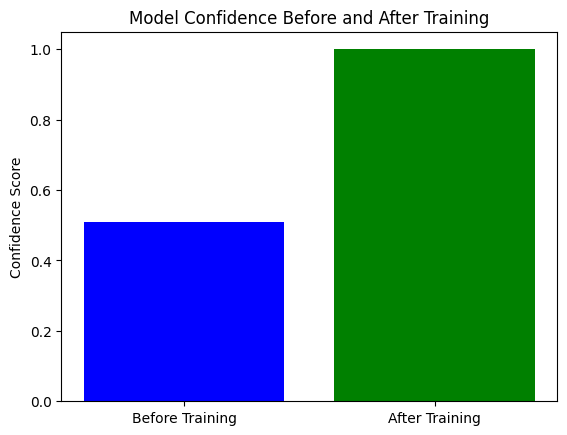

In [ ]:
# Load the IMDB dataset
dataset = load_dataset("imdb", split="train[:2000]").train_test_split(test_size=0.2)
metric = load_metric("accuracy")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Define the preprocessing function
def preprocess(data):
    return tokenizer(data['text'], padding=True, truncation=True)

# Preprocess the dataset
dataset = dataset.map(preprocess, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Load models
raw_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Define the compute_metrics function
def compute_metrics(pred):
    predictions = torch.tensor(pred.predictions)
    labels = torch.tensor(pred.label_ids)
    preds = torch.argmax(predictions, axis=1)
    return metric.compute(predictions=preds, references=labels)

# Initialize the Trainer for fine-tuning
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,  # Increased number of epochs for better training
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

# Note: Use the same raw_model to train and evaluate as fine_tuned_model
trainer = Trainer(
    model=fine_tuned_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Evaluate the model before fine-tuning
classifier_before = pipeline("sentiment-analysis", model=raw_model, tokenizer=tokenizer)
input_text = "I love this movie, it's amazing!"
output_before = classifier_before(input_text)
print(f"Before training: {output_before}")

# Train the model
trainer.train()

# Evaluate the model after fine-tuning
classifier_after = pipeline("sentiment-analysis", model=fine_tuned_model, tokenizer=tokenizer)
output_after = classifier_after(input_text)
print(f"After training: {output_after}")

# Visualize the difference in confidence scores
labels = ['Before Training', 'After Training']
scores = [output_before[0]['score'], output_after[0]['score']]

plt.bar(labels, scores, color=['blue', 'green'])
plt.title('Model Confidence Before and After Training')
plt.ylabel('Confidence Score')
plt.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000100,0.000055,1.000000
2,0.000000,0.000019,1.000000
3,0.000000,0.000014,1.000000


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


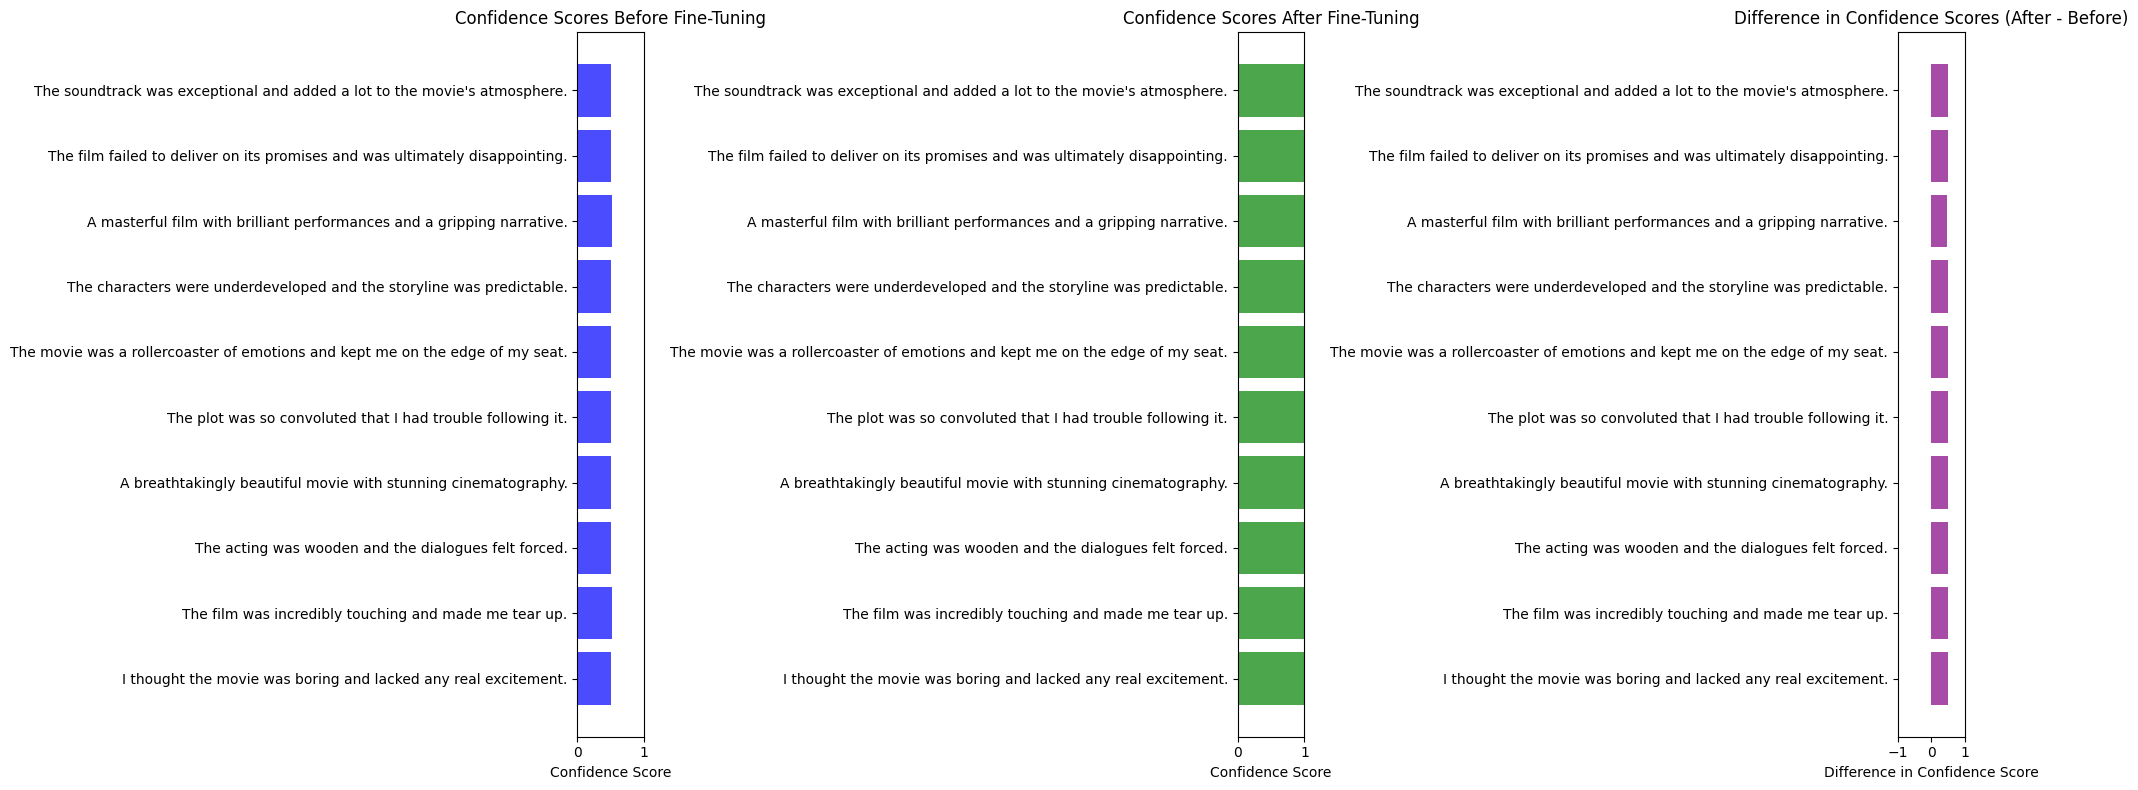

In [ ]:
# Load the IMDB dataset
dataset = load_dataset("imdb", split="train[:2000]").train_test_split(test_size=0.2)
metric = load_metric("accuracy")

# Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
raw_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Define preprocessing function
def preprocess(data):
    return tokenizer(data['text'], padding=True, truncation=True)

# Preprocess the dataset
dataset = dataset.map(preprocess, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Define compute_metrics function
def compute_metrics(pred):
    predictions = torch.tensor(pred.predictions)
    labels = torch.tensor(pred.label_ids)
    preds = torch.argmax(predictions, axis=1)
    return metric.compute(predictions=preds, references=labels)

# Initialize Trainer for fine-tuning
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,  # Increased number of epochs for better training
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)
trainer = Trainer(
    model=fine_tuned_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Define questions for evaluation
questions = [
    "I thought the movie was boring and lacked any real excitement.",
    "The film was incredibly touching and made me tear up.",
    "The acting was wooden and the dialogues felt forced.",
    "A breathtakingly beautiful movie with stunning cinematography.",
    "The plot was so convoluted that I had trouble following it.",
    "The movie was a rollercoaster of emotions and kept me on the edge of my seat.",
    "The characters were underdeveloped and the storyline was predictable.",
    "A masterful film with brilliant performances and a gripping narrative.",
    "The film failed to deliver on its promises and was ultimately disappointing.",
    "The soundtrack was exceptional and added a lot to the movie's atmosphere."
]

# Evaluate the model before fine-tuning
classifier_before = pipeline("sentiment-analysis", model=raw_model, tokenizer=tokenizer)
results_before = [classifier_before(question)[0] for question in questions]

# Train the model
trainer.train()

# Evaluate the model after fine-tuning
classifier_after = pipeline("sentiment-analysis", model=fine_tuned_model, tokenizer=tokenizer)
results_after = [classifier_after(question)[0] for question in questions]

# Extract scores
scores_before = [result['score'] for result in results_before]
scores_after = [result['score'] for result in results_after]

# Normalize scores to be between 0 and 1
scores_before = np.clip(scores_before, 0, 1)
scores_after = np.clip(scores_after, 0, 1)

# Calculate differences in scores
differences = np.array(scores_after) - np.array(scores_before)

# Plot scores before fine-tuning
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.barh(questions, scores_before, color='blue', alpha=0.7)
plt.xlabel('Confidence Score')
plt.title('Confidence Scores Before Fine-Tuning')
plt.xlim(0, 1)  # Ensure x-axis is between 0 and 1

# Plot scores after fine-tuning
plt.subplot(1, 3, 2)
plt.barh(questions, scores_after, color='green', alpha=0.7)
plt.xlabel('Confidence Score')
plt.title('Confidence Scores After Fine-Tuning')
plt.xlim(0, 1)  # Ensure x-axis is between 0 and 1

# Plot differences
plt.subplot(1, 3, 3)
plt.barh(questions, differences, color='purple', alpha=0.7)
plt.xlabel('Difference in Confidence Score')
plt.title('Difference in Confidence Scores (After - Before)')
plt.xlim(-1, 1)  # Ensure x-axis includes potential negative differences

plt.tight_layout()
plt.show()

